In [3]:
import sys
sys.path.append('..')
import config as conf
import functions.parallelization_functions as parallel_funcs

paths = conf.DataFilePaths()
params = conf.ARIMA_model_parameters()

import statistics
import multiprocessing as mp
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statistics import NormalDist

In [4]:
# Load and inspect results - each row is an individual datapoint from one of the conditions/samples
input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}.parquet'
data_df = pd.read_parquet(input_file)
data_df.head()

,sample,model_type,lag_order,difference_degree,moving_average_order,SMAPE_value,MBD_prediction,MBD_inputs,MBD_actual
0,0,control,4,1,4,0.006948,3.663699,"[3.5651729, 3.5834184, 3.6491022, 3.6636987, 3...",3.689242
1,0,ARIMA,4,1,4,0.013054,3.641394,"[3.5651729, 3.5834184, 3.6491022, 3.6636987, 3...",3.689242
2,0,control,4,1,4,0.009737,6.059894,"[5.8367586, 5.8367586, 5.9659424, 6.0598941, 6...",6.001174
3,0,ARIMA,4,1,4,0.035896,6.220528,"[5.8367586, 5.8367586, 5.9659424, 6.0598941, 6...",6.001174
4,0,control,4,1,4,0.007273,2.111591,"[2.0499384, 2.0961776, 2.0807645, 2.1115906, 2...",2.127004


In [6]:
# Calculate the final SMAPE score for each sample in each condition
sample_smape_scores_df = data_df.groupby(['sample', 'model_type', 'lag_order', 'difference_degree', 'moving_average_order'])[['SMAPE_value']].mean().mul(100)

# Rename columns to reflect the change from SMAPE values for a single prediction to
# SMAPE scores within a sample
sample_smape_scores_df.rename(inplace=True, columns={'SMAPE_value': 'SMAPE_score'})

# Clean up index and inspect. Now each sample in all of the conditions is represented by a single row
# with two SMAPE scores calculated from all of the datapoints in that condition and sample. One from
# the fit and forecast on the raw data and the other from the fit and forecast on the difference
# detrended data
sample_smape_scores_df.reset_index(inplace=True, drop=False)
sample_smape_scores_df.head()

,sample,model_type,lag_order,difference_degree,moving_average_order,SMAPE_score
0,0,ARIMA,4,1,4,1.708486
1,0,ARIMA,4,1,6,1.001148
2,0,ARIMA,4,2,4,4.758800
3,0,ARIMA,4,2,6,2.532176
4,0,ARIMA,6,1,4,9.271457


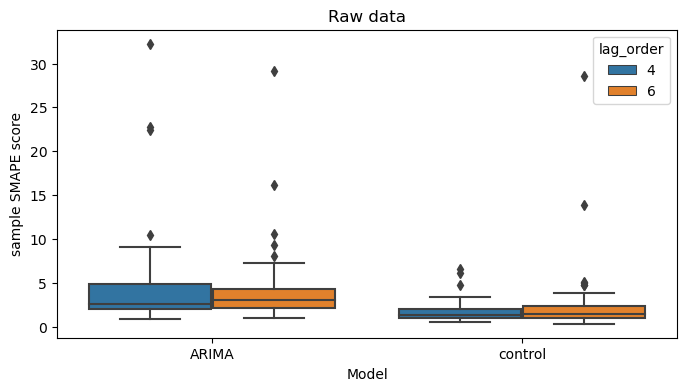

In [7]:
fig, ax = plt.subplots(1, 1,figsize=(8,4))

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='SMAPE_score',
    hue='lag_order',
    ax=ax
)

ax.set(
    xlabel='Model', 
    ylabel='sample SMAPE score', 
    title='Raw data'
)

plt.show()